In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer
import xgboost as xgb

In [3]:
label_feature = 'Danceability'
numerical_features = ['Energy', 'Loudness', 'Speechiness', 'Acousticness',
                      'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Stream',
                      'Views', 'Likes', 'Comments']

categorical_features = ['Album_type', 'Key', 'Licensed', 'official_video']

string_features = [
    'Track', 'Artist', 'Composer', 'Album', 'Title', 'Channel', 'Description'
]

# Define used features

In [5]:
from my_transformer import MyTransformer
import pandas as pd
import numpy as np

# label
label_feature = 'Danceability'

# features
dont_transform_features = ['Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence']
normal_transform_features = ['Tempo']
power_transform_features = ['Loudness', 'Duration_ms', 'Stream', 'Views', 'Likes', 'Comments']
categorical_features = ['Album_type', 'Key', 'Licensed', 'official_video']
numerical_features=dont_transform_features + normal_transform_features + power_transform_features

# all features
features_columns = dont_transform_features + normal_transform_features + power_transform_features + categorical_features
label_column = label_feature

# import data
train_df = pd.read_csv('data/train.csv')[features_columns + [label_column]]
test_df = pd.read_csv('data/test.csv')[features_columns]
test_ids = pd.read_csv('data/test.csv')['id']

# init transformer
my_transformer = MyTransformer(
    all_features=features_columns,
    categorical_features=categorical_features,
    normal_transform_features=normal_transform_features,
    power_transform_features=power_transform_features,
    numerical_features=dont_transform_features + normal_transform_features + power_transform_features,
    label_column=label_column,
)

# transform dataset
train_X_df = my_transformer.features_fit_transform(train_df)
train_Y_df = my_transformer.label_fit_transform(train_df)
test_X_df = my_transformer.features_transform(test_df)

# to numpy
train_X = train_X_df.to_numpy()
train_Y = train_Y_df.to_numpy()
test_X = test_X_df.to_numpy()

feature_size = train_X.shape[1]
output_size = 1

# preprocess features

In [10]:
X, Y = train_X, train_Y.reshape(-1)

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

def custom_scorer(y_true, y_pred):
    y_pred = my_transformer.inverse_label_transform(y_pred)
    y_pred = np.clip(np.round(y_pred), 0, 9)
    y_true = my_transformer.inverse_label_transform(y_true)
    print(mean_absolute_error(y_true, y_pred))
    return -mean_absolute_error(y_true, y_pred)

# Create an instance of the HistGradientBoostingRegressor
model = xgb.XGBRegressor

# Perform grid search with cross-validation
scoring = make_scorer(custom_scorer)
grid_search = GridSearchCV(model(), param_grid, scoring=scoring, cv=5)
grid_search.fit(X, Y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Create a new instance of HistGradientBoostingRegressor with the best parameters
trained_model = model(**best_params)

# Fit the best HistGradientBoostingRegressor on the entire dataset
trained_model = trained_model.fit(X, Y)
# train loss
y_pred = trained_model.predict(X)
train_err = custom_scorer(Y, y_pred)

print(f'train loss: {train_err}')

1.6458940011648224
1.6683168316831682
1.6304601048340128
1.6735585323238207
1.7157833430401863
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Score: 1.666802562609202
0.9529411764705882
train loss: -0.9529411764705882


(array([ 669., 1196., 1610., 2000., 2391., 2674., 2692., 2419., 1286.,
         233.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

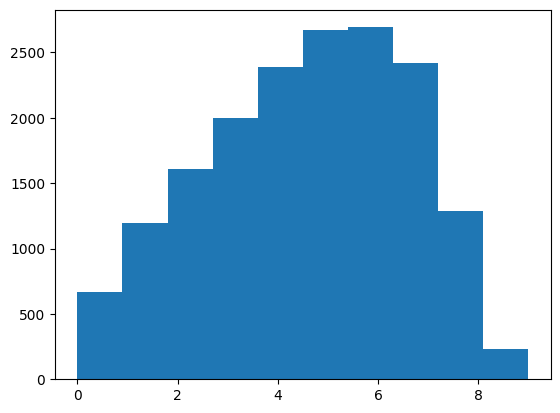

In [17]:
# Make predictions on the test set
test_predictions = trained_model.predict(train_X)
test_predictions = my_transformer.inverse_label_transform(test_predictions)
test_predictions = np.clip(np.round(test_predictions), 0, 9)
test_predictions = test_predictions.astype(int).reshape(-1)

# Prepare the submission dataframe
submission_df = pd.DataFrame({'id': test_ids, 'Danceability': test_predictions})

# Save the submission to a CSV file
submission_df.to_csv('submission.csv', index=False)

import matplotlib.pyplot as plt

plt.hist(test_predictions, bins=10)